In [1]:
import numpy as np
import pandas as pd
import os 
import numpy as np
import pandas as pd
import sys
import shap
import copy
#sys.path.append('/Users/kojiroyamamoto/LightGBM/python-package/')
from models.model_lgb import ModelLGB
from models.model_logistic import ModelLogistic
#from models.model_xgb import ModelXGB

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
pd.set_option("display.max_column",500)

In [2]:
train = pd.read_csv("./data/input/train.csv")
y = train["target"]
X_train = pd.read_csv("./data/input/X_train.csv")
X_test = pd.read_csv("./data/input/X_test.csv")

train_x, va_x, train_y, va_y = train_test_split(X_train,y ,test_size=0.2,random_state=42)

In [3]:
X_train.head()

,bin_0,bin_1,bin_2,ord_0,day,month,bin_3_num,bin_4_num,nom_0_num,nom_1_num,nom_2_num,nom_3_num,nom_4_num,nom_5_num,nom_6_num,nom_7_num,nom_8_num,nom_9_num,ord_1_num,ord_2__num,ord_3_num,ord_4_num,ord_5_oe1,ord_5_oe2,day_sin,day_cos,month_sin,month_cos
0,0.0,0.0,0.0,3.0,6.0,3.0,0.0,0.0,2,4,3,5,0,1059,1013,87,1,27,2.0,4.0,3.0,21.0,41.0,22.0,-7.818315e-01,0.623490,1.000000e+00,6.123234e-17
1,1.0,1.0,0.0,3.0,7.0,7.0,0.0,1.0,2,3,0,6,3,210,359,27,69,2112,5.0,3.0,5.0,24.0,15.0,30.0,-2.449294e-16,1.000000,-5.000000e-01,-8.660254e-01
2,0.0,1.0,0.0,3.0,5.0,9.0,0.0,0.0,2,6,3,0,0,860,694,90,102,2218,NaN,1.0,14.0,16.0,4.0,39.0,-9.749279e-01,-0.222521,-1.000000e+00,-1.836970e-16
3,NaN,0.0,0.0,1.0,3.0,3.0,0.0,0.0,2,0,3,3,3,477,241,51,170,2167,1.0,6.0,1.0,3.0,NaN,NaN,4.338837e-01,-0.900969,1.000000e+00,6.123234e-17
4,0.0,NaN,0.0,3.0,5.0,12.0,1.0,0.0,2,5,3,2,4,556,361,182,222,1747,5.0,2.0,8.0,3.0,40.0,51.0,-9.749279e-01,-0.222521,-2.449294e-16,1.000000e+00


In [4]:
params_lgb = {
       "objective": "binary",
        "metric": "binary_logloss",
        'random_state': 71,
        'num_round': 20000,
       'eta' : 0.1,
        'early_stopping_rounds':100
    }

model = ModelLGB()


In [5]:
model.train(train_x, train_y,va_x=va_x,va_y=va_y,params=params_lgb)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[573]	valid_0's binary_logloss: 0.404947


In [7]:
va_pred = model.predict(va_x)

print("ROC_score  {:.3f}".format(roc_auc_score(va_y,np.round(va_pred))))
print("Accurecy  {:.3f}".format(accuracy_score(va_y,np.round(va_pred))))
print("Precision {:.3f}".format(precision_score(va_y,np.round(va_pred))))
print("Recall {:.3f}".format(recall_score(va_y,np.round(va_pred))))
print(confusion_matrix(va_y,np.round(va_pred)))

ROC_score  0.569
Accurecy  0.823
Precision 0.588
Recall 0.166
[[95043  2597]
 [18659  3701]]


In [31]:
counts = (train_y==1).sum()
prob = counts/len(train_y)
w = [1/prob if y==1 else 1 for y in train_y]

model.train(train_x, train_y,va_x=va_x,va_y=va_y,params=params_lgb,weight=w)
model.save_model("lgb_w_0316")

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's binary_logloss: 0.596579
[2000]	valid_0's binary_logloss: 0.575074
[3000]	valid_0's binary_logloss: 0.557603
[4000]	valid_0's binary_logloss: 0.543313
[5000]	valid_0's binary_logloss: 0.531533
[6000]	valid_0's binary_logloss: 0.522324
[7000]	valid_0's binary_logloss: 0.51379
[8000]	valid_0's binary_logloss: 0.50702
[9000]	valid_0's binary_logloss: 0.501795
[10000]	valid_0's binary_logloss: 0.497238
[11000]	valid_0's binary_logloss: 0.49334
[12000]	valid_0's binary_logloss: 0.490113
[13000]	valid_0's binary_logloss: 0.487354
[14000]	valid_0's binary_logloss: 0.485203
[15000]	valid_0's binary_logloss: 0.483609
[16000]	valid_0's binary_logloss: 0.48223
[17000]	valid_0's binary_logloss: 0.48123
Early stopping, best iteration is:
[17523]	valid_0's binary_logloss: 0.480789


In [87]:
model.load_model("lgb_w_0316")
va_pred = model.predict(va_x)

print("ROC_score  {:.3f}".format(roc_auc_score(va_y,va_pred)))
print("Accurecy  {:.3f}".format(accuracy_score(va_y,np.round(va_pred))))
print("Precision {:.3f}".format(precision_score(va_y,np.round(va_pred))))
print("Recall {:.3f}".format(recall_score(va_y,np.round(va_pred))))
print(confusion_matrix(va_y,np.round(va_pred)))

ROC_score  0.738
Accurecy  0.778
Precision 0.408
Recall 0.425
[[83871 13769]
 [12863  9497]]


In [61]:
sample = pd.read_csv("./data/input/sample_submission.csv")

In [8]:
#shap
model_lgm = ModelLGB()
model_lgm.load_model("lgb_w_0316")

#notebook内でJavascriptを動かすためのおまじない
shap.initjs()

#modelと解釈したいデータを渡す。
explainer = shap.TreeExplainer(model=model_lgm.model)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [12]:
shap_data = copy.deepcopy(va_x.iloc[0:1000,:])
shap_values = explainer.shap_values(X=shap_data)

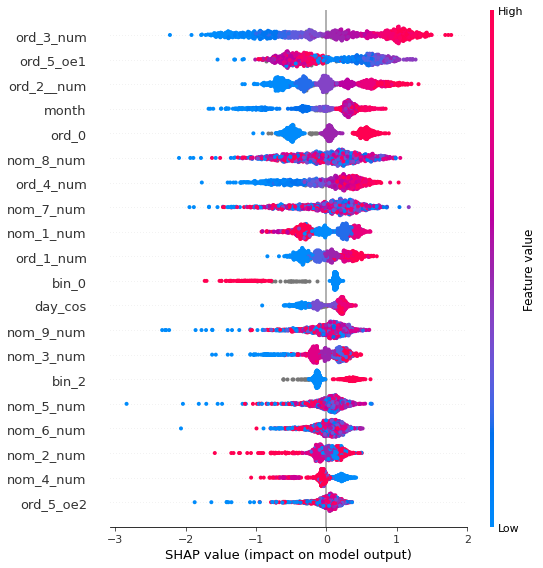

In [23]:
shap.summary_plot(shap_values[1],shap_data)

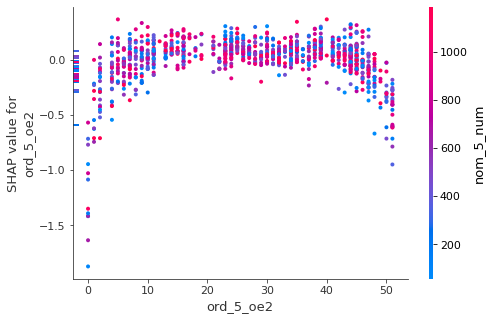

In [21]:
shap.dependence_plot("ord_5_oe2", shap_values[1],shap_data)

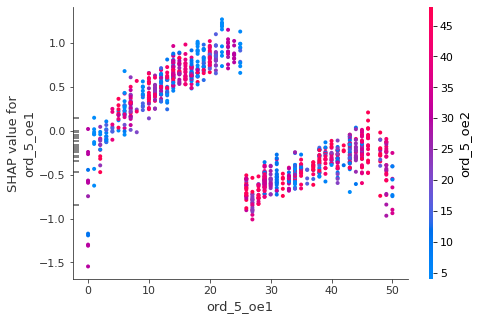

In [17]:
shap.dependence_plot("ord_5_oe1", shap_values[1],shap_data)

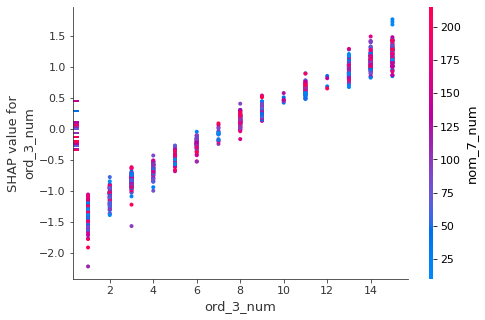

In [22]:
shap.dependence_plot("ord_3_num", shap_values[1],shap_data)

In [20]:
import string
string.ascii_letters.find("a")

0

In [39]:
model_logi = ModelLogistic()

In [72]:
from sklearn.preprocessing import StandardScaler

train_x_logi = copy.deepcopy(train_x)
va_x_logi = copy.deepcopy(va_x)
X_test_logi = copy.deepcopy(X_test)

for col in train_x_logi.columns:
    train_x_logi[col] = train_x_logi[col].fillna(np.nanmean(train_x_logi[col]))
    va_x_logi[col] = va_x_logi[col].fillna(np.nanmean(va_x_logi[col]))
    X_test_logi[col] = X_test_logi[col].fillna(np.nanmean(X_test_logi[col]))
    
fit_sc = StandardScaler()
train_x_logi  = fit_sc.fit_transform(train_x_logi)
va_x_logi  = fit_sc.fit_transform(va_x_logi)
X_test_logi   = fit_sc.fit_transform(X_test_logi)


In [60]:
model_logi.train(train_x_logi, train_y)
model_logi.save_model("logi_0316")

In [96]:
va_pred_logi = model_logi.model.predict_proba(va_x_logi)[:,1]

print("ROC_score  {:.3f}".format(roc_auc_score(va_y,va_pred_logi)))
print("Accurecy  {:.3f}".format(accuracy_score(va_y,np.round(va_pred_logi))))
print("Precision {:.3f}".format(precision_score(va_y,np.round(va_pred_logi))))
print("Recall {:.3f}".format(recall_score(va_y,np.round(va_pred_logi))))
print(confusion_matrix(va_y,np.round(va_pred_logi)))

ROC_score  0.732
Accurecy  0.817
Precision 0.550
Recall 0.094
[[95929  1711]
 [20269  2091]]


In [100]:
va_pred_all = np.average([va_pred_logi,va_pred],axis=0,weights=[1,1])

print("ROC_score  {:.3f}".format(roc_auc_score(va_y,va_pred_all)))
print("Accurecy  {:.3f}".format(accuracy_score(va_y,np.round(va_pred_all))))
print("Precision {:.3f}".format(precision_score(va_y,np.round(va_pred_all))))
print("Recall {:.3f}".format(recall_score(va_y,np.round(va_pred_all))))
print(confusion_matrix(va_y,np.round(va_pred_all)))

ROC_score  0.752
Accurecy  0.812
Precision 0.492
Recall 0.267
[[91492  6148]
 [16401  5959]]


In [ ]:
model.load_model("lgb_w_0316")
pred_lgb = model.predict(X_test)
model_logi.load_model("logi_0316")
pred_logi = model_logi.model.predict_proba(X_test_logi)

In [ ]:
pred_all = np.average([pred_logi[:,1],pred_lgb],axis=0,weights=[1,1])

In [104]:
sample["target"] = pred_all
sample.to_csv("data/output/lgb_logit_0316.csv",index=False)

In [4]:
# Khold

params_lgb = {
       "objective": "binary",
        "metric": "binary_logloss",
        'random_state': 71,
        'num_round': 20000,
       'eta' : 0.1,
        'early_stopping_rounds':100
    }

model_lgb = ModelLGB()



In [ ]:
model_lgb.